# Exploratory data analysis
For this exploration of the data the files are read in and inspected for missing values, data types and availability of data needed to answer business questions.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Analysis plan
The datasets consists of three files, `calendar` entries, property `listings` and `reviews`. The `reviews` data file will be ignored for this project due to it only containing text information and NLP is out of scope.

The goal of this project is to answer the following question in a blogpost:
1. What influences the price of a stay in Seattle the most?

This can be divided in two subquestions:
1. Do prices get influenced by seasonal trends? (does it matter when you book your stay)
1. Which factors influence a properties base listing price the most?
  
To answer these we'll start with basic data exploration and cleaning and finish up using a randomforest regressor to determine which features actually affect the price the most. During the initial cleaning of the data a subset of columns is dropped from the `listing` data, reasons explained below

After both `calendar` and `listing` data is loaded in, the dataframes are joined together to enrich the dataset for further exploration, adding location data to the calendar overview.

In [2]:
def df_summary_overview(df):
    """Take a pandas DataFrame and display the shape, provide info on the columns
    and display the 5 first and 5 last rows of the data. 5 last to see if there are total/summary
    rows included in the data
    """
    # print shape information
    rows, columns = df.shape
    print(f'This dataset has {rows} rows & {columns} columns\n')
    
    # Display a small example
    display(df.head(5))
    display(df.tail(5))
    
    # Describe the dataframe
    display(df.info(memory_usage=False))

    
## Cleaning data
def clean_and_cast_price(price):
    """Take the price and clean the commas and dollar signs"""
    if pd.isnull(price):
        return price
    else:
        return price.replace('$','').replace(',','')

## Looking at the calendar data

- The data has three columns and seems to only have missing values for the `price` column.
- The `date` column is an object, for each of processing lets turn this into a datetime column
- The `available` column is a boolean but is stored as object with t/f values.
- The prices have a `$` symbol and are stored as objects.


In [3]:
# Read the data and get summary overview
calendar = pd.read_csv('data/airbnb_seatle/calendar.csv')
df_summary_overview(calendar)

This dataset has 1393570 rows & 4 columns



,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


,listing_id,date,available,price
1393565,10208623,2016-12-29,f,NaN
1393566,10208623,2016-12-30,f,NaN
1393567,10208623,2016-12-31,f,NaN
1393568,10208623,2017-01-01,f,NaN
1393569,10208623,2017-01-02,f,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)

None

### Preprocess calendar data
- Clean price column, remove $ and comma for thousands and cast to float
- Cast the available column to boolean
- Change the date column to a datetime object

In [4]:
# Clean the $ sign from the price column, remove the commas (,) for the thousands and cast to float
calendar.loc[:,'price'] = (calendar['price']
                           .apply(clean_and_cast_price)
                           .astype(float)
                          )

In [5]:
# Change available column to boolean
calendar.loc[:,'available'] = calendar['available'] == 't'

In [6]:
# Update datetype for date
calendar.loc[:,'date'] = pd.to_datetime(calendar['date'])

### Explore calendar data
- Check the missing values in the pricing column
- See if some listings are missing all pricing information
- Check pricing range, any outliers?

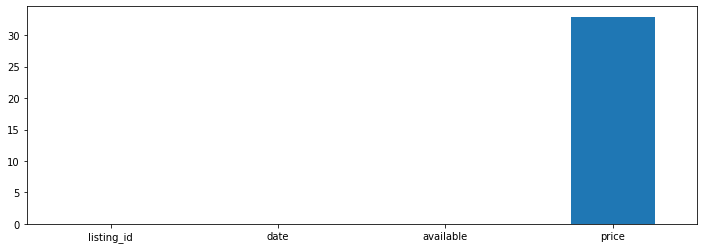

In [7]:
## Plot missing values
(calendar.isnull().mean()*100).plot(kind='bar', figsize=(12,4), rot=0);

# Only price seems to be missing, is there a pattern to which lines are missing this?

In [8]:
# Check for which dates the price is missing, looks like this might be tied to availability

# Select only unavailable rooms, check unique list of prices
print(f"Unique prices in unavailable rooms: {calendar.loc[~calendar['available'],'price'].unique()}")


# Check null values in available listings
print(f"Available rooms, price unknown: {calendar.loc[calendar['available'],'price'].isnull().sum()}")

# So the prices for available rooms are known, when unavailable they are unknown

Unique prices in unavailable rooms: [nan]
Available rooms, price unknown: 0


In [9]:
# Are there properties for which the price is unknown?
# Use groupby with maximum price to determine
calendar_max_prices = calendar.groupby('listing_id').price.max()

# listings missing prices, check listing data to get prices?
calendar_listings_no_price = calendar_max_prices[calendar_max_prices.isnull()].index.tolist()


print(f"There are {len(calendar_listings_no_price)} listings that do not have a price in the calendar at all")

# Missing a price might be in the listings data file.

There are 95 listings that do not have a price in the calendar at all


In [10]:
# Prices per listing seem to change over time. Only ~13% of the listings have 1 price for the whole year,\
# The rest is subject to change

number_of_pricings = calendar.groupby('listing_id').apply(lambda x: x.price.unique().size).value_counts()
print(f'Number of listings with same price for the whole year: {number_of_pricings[1]/number_of_pricings.sum()*100:.2f}%')

Number of listings with same price for the whole year: 12.83%


## Looking at the Listings data
The listings data has a lot of columns with information around the listing. It includes summary summary statistics on the listing like number of reviews, average review rating, location of the listing and information about the listing in general.

For the EDA, lets have a look at some of the columns and identify some columns that might provide interesting information we can use to answer questions.

There are a bunch of columns that do not add any additional information, lets remove them to reduce the clutter the size of the dataset and make it easier to keep an overview.

In [11]:
listings = pd.read_csv('data/airbnb_seatle/listings.csv')
df_summary_overview(listings)

This dataset has 3818 rows & 92 columns



,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
3813,8101950,https://www.airbnb.com/rooms/8101950,20160104002432,2016-01-04,3BR Mountain View House in Seattle,Our 3BR/2BA house boasts incredible views of t...,"Our 3BR/2BA house bright, stylish, and wheelch...",Our 3BR/2BA house boasts incredible views of t...,none,We're located near lots of family fun. Woodlan...,...,8.0,f,NaN,WASHINGTON,f,strict,f,f,8,0.3
3814,8902327,https://www.airbnb.com/rooms/8902327,20160104002432,2016-01-04,Portage Bay View!-One Bedroom Apt,800 square foot 1 bedroom basement apartment w...,This space has a great view of Portage Bay wit...,800 square foot 1 bedroom basement apartment w...,none,The neighborhood is a quiet oasis that is clos...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,2.0
3815,10267360,https://www.airbnb.com/rooms/10267360,20160104002432,2016-01-04,Private apartment view of Lake WA,"Very comfortable lower unit. Quiet, charming m...",NaN,"Very comfortable lower unit. Quiet, charming m...",none,NaN,...,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN
3816,9604740,https://www.airbnb.com/rooms/9604740,20160104002432,2016-01-04,Amazing View with Modern Comfort!,Cozy studio condo in the heart on Madison Park...,Fully furnished unit to accommodate most needs...,Cozy studio condo in the heart on Madison Park...,none,Madison Park offers a peaceful slow pace upsca...,...,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN
3817,10208623,https://www.airbnb.com/rooms/10208623,20160104002432,2016-01-04,Large Lakefront Apartment,"All hardwood floors, fireplace, 65"" TV with Xb...",NaN,"All hardwood floors, fireplace, 65"" TV with Xb...",none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

None

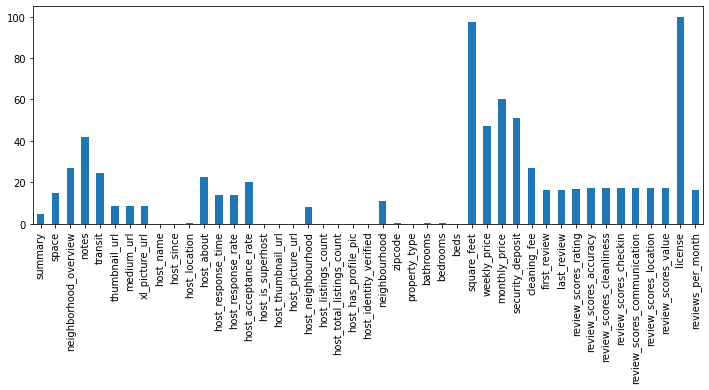

In [12]:
## Plot missing values as percentage missing
(listings.isnull().mean()*100)[~listings.notnull().all()].plot(kind='bar', figsize=(12,4));

There are a few columns that are low information as they have a large percentage missing values. See below for a list of columns that will be dropped from the data.

Next to that there are a few columns that have missing values that might be interesting. Two columns that stick out that might be interesting are `property_type` and `neighbourhood`. These are interesting as I want to have a look at the property type and neighbourhood influence on the price. Lets see if we can fill in the missing data.

#### handling missing values for `property_type`

In [13]:
## Check only missing property with subset of values.
listings[listings.property_type.isnull()][['id','name','summary','property_type','neighbourhood','bathrooms','bedrooms']]

,id,name,summary,property_type,neighbourhood,bathrooms,bedrooms
2184,3335,Sweet Seattle Urban Homestead 2 Bdr,Welcome! If you stay here you will be living i...,NaN,Dunlap,1.0,2.0


In [14]:
## Use the homestead from the description to figure out which property_type uses this the most, fill that in
listings[listings.name.str.contains('omestead')].property_type.value_counts()

House        6
Treehouse    1
Name: property_type, dtype: int64

In [15]:
## fill in house as most used
listings.loc[listings.id==3335,'property_type'] = 'House'

#### Investigate missing values in neighbourhood
Instead of imputing the missing values in `neighbourhood` there is another column we could use instead, `neighbourhood_cleansed`, this doesn't have any empty values.

In [16]:
listings[listings.neighbourhood.isnull()][['zipcode','neighbourhood','neighbourhood_cleansed']].isnull().sum()

zipcode                     3
neighbourhood             416
neighbourhood_cleansed      0
dtype: int64

#### Dropping low information columns from the listings DataFrame

In [17]:
# Drop all low information columns, and columns with insufficient data to recover from missing data.

drop_columns = [
    'experiences_offered', # only none as value
    
    # Cleaning all URLs from the property
    'thumbnail_url', # not interested in this, 320 missing, so around 90% of the properties have this
    'medium_url',
    'picture_url',
    'xl_picture_url',
    'host_url', # dropping as we have the host_id.
    'host_thumbnail_url',
    'host_picture_url',
    
    'city', # This is single value, Seattle, with very high generic flavours. Neighbourhood gives more information
    'state', # Same as city, single value
    'market', # single value, Seattle
    'smart_location', # Same issue as city
    'country_code', # one value
    'country', # one value,
    'jurisdiction_names', # one value
    
    'square_feet', # too many missing values that can't be recovered otherwise
    'license' # Only missing values
               ]

listings = listings.drop(columns=drop_columns)

In [18]:
# Fix listing price, removing $ signs and commas from all dollar amount columns
price_cols = ['price','weekly_price','monthly_price', 'extra_people']
listings.loc[:,price_cols] = (listings[price_cols]
                             .applymap(clean_and_cast_price)
                             .astype(float)
                            )


In [19]:
# Check if listings are duplicated based on the id column
listings.id.value_counts().max()

1

## Combine Calendar and Listings into one dataframe
Enrich the calendar data set with the listings data of interest.


**Filling missing prices**  
To impute missing values for the calendar we'll use the last known value carried forward for missing prices. There are 95 properties that do not have any values in the calendar dataset, so forward filling the data will not work in that case. For those properties the price from the listing overview will be inserted.

forward filling the data takes care of a lot of missing values but it doesn't cover all missing values. As mentioned for the 95 properties it doesn't insert any values, the forward fill will also fail to impute any missing values if the first observation of a property isn't known. To stay consistent with the 95 missing properties these values are filled using the price values as listed in the listings dataset.



In [20]:
## Use groupby with a ffill to fill the missing values
calendar.loc[:,'price_locf'] = (calendar
                                .groupby('listing_id', as_index=False)
                                .fillna(method='ffill')
#                                 .fillna(method='bfill') # Use backfill to get latest value to populate forward
                               ).price

In [21]:
df = calendar.merge(listings, left_on = 'listing_id', right_on = 'id', how='left', suffixes=('','_listings'))
df.head()

,listing_id,date,available,price,price_locf,id,listing_url,scrape_id,last_scraped,name,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,2016-01-04,True,85.0,85.0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07
1,241032,2016-01-05,True,85.0,85.0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07
2,241032,2016-01-06,False,NaN,85.0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07
3,241032,2016-01-07,False,NaN,85.0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07
4,241032,2016-01-08,False,NaN,85.0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07


In [22]:
df['price_coalesce'] = df.price_locf.combine_first(df.price_listings)

In [23]:
## Check number of listings with any null values for the price
df[df.price_coalesce.isnull()].listing_id.unique().size

0

### Data enrichment
To make the temporal and seasonal analysis a little bit easier helper columns are introduced.
- `date_month`; to get an easy overview per month
- `day_of_week`; to inspect prices over the weekend

In [24]:
df['date_month'] = df.date.dt.month_name()

df['day_of_week'] = df.date.dt.day_name()

## Summary statistics

Get a feel for how many lines of data we have, how many properties and with what price range. Look at some fields that from gut feeling might affect the price heavily, like property type and size of the property (how many people it accomodates).

Plot the price distributions to see how the prices are distributed on the properties in Seattle. Add visual inspection of the price over time displaying the seasonal trend in the data.

Lastly investigate the influence of the neighbourhood on the prices.

In [25]:
## Get an idea of the size of the data
nrows, ncolumns = df.shape

print(f'Found {nrows} calendar lines over a period between '\
      f'{df.date.min().strftime("%Y-%m-%d")} and {df.date.max().strftime("%Y-%m-%d")} '\
      f'for {df.listing_id.unique().size} properties'
     )

Found 1393570 calendar lines over a period between 2016-01-04 and 2017-01-02 for 3818 properties


In [26]:
## Check the value_counts for property types
print((listings.property_type.value_counts().to_frame()
 .join(
     listings.property_type.value_counts(normalize=True)*100,
     rsuffix='_percentage'
 )
).to_markdown(floatfmt=".2f"))

|                 |   property_type |   property_type_percentage |
|:----------------|----------------:|---------------------------:|
| House           |         1734.00 |                      45.42 |
| Apartment       |         1708.00 |                      44.74 |
| Townhouse       |          118.00 |                       3.09 |
| Condominium     |           91.00 |                       2.38 |
| Loft            |           40.00 |                       1.05 |
| Bed & Breakfast |           37.00 |                       0.97 |
| Other           |           22.00 |                       0.58 |
| Cabin           |           21.00 |                       0.55 |
| Bungalow        |           13.00 |                       0.34 |
| Camper/RV       |           13.00 |                       0.34 |
| Boat            |            8.00 |                       0.21 |
| Tent            |            5.00 |                       0.13 |
| Treehouse       |            3.00 |                       0.

The property types seem very skewed, to highlight how skewed these are I will group them in the main 3 categories, House, Apartment, and Other, relabelling everything to Other that is not a House or an Apartment.

You could argue that property_types like Townhouse could be counted towards the House property type.

#### Introducting `property_category` 

In [27]:
listings['property_category'] = listings.property_type
listings.loc[~listings.property_type.isin(['House','Apartment']),'property_category'] = 'Other'
listings.property_category.value_counts()

House        1734
Apartment    1708
Other         376
Name: property_category, dtype: int64

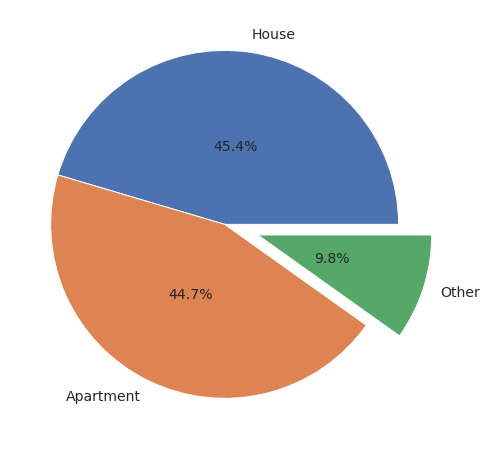

In [28]:
sns.set()
fig,ax = plt.subplots(figsize=(8,8))
listings.property_category.value_counts().plot.pie(autopct='%.1f%%',
                                                   explode=[0,0,0.2],
                                                   pctdistance=0.45,
                                                   fontsize=14
                                                  )
ax.set_ylabel('');
sns.reset_defaults()

In [29]:
## Get pricing overview from the calendar
min_price = df.price_coalesce.min()
max_price = df.price_coalesce.max()
mean_price = df.price_coalesce.mean()

print(f'Properties are priced between ${min_price:.2f} and ${max_price:.2f} with a average price ${mean_price:.2f} per night from the calendar')

## Look at general prices on the listings
print(f'The properties are listed with a minimum price of ${listings.price.min():.2f} and maximum of ${listings.price.max():.2f}')

Properties are priced between $10.00 and $1650.00 with a average price $136.99 per night from the calendar
The properties are listed with a minimum price of $20.00 and maximum of $1000.00


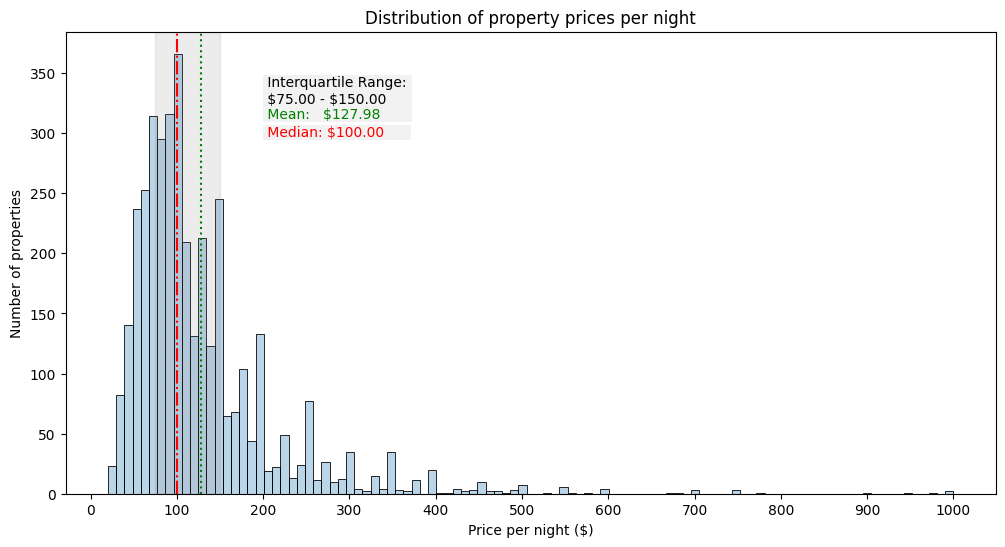

In [30]:
## Looking at the price distribution over all properties
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(data=listings, x='price', ax=ax, alpha=0.3);
ax.set_xlabel('Price per night ($)')
ax.set_ylabel('Number of properties');
ax.set_xticks([i for i in range(0,1100,100)])

ax.set_title('Distribution of property prices per night')

bbox = {'fc': '0.95', 'pad': 0.5, 'ec':'none'}
# Add mean
x_mean = listings.price.mean()
ax.axvline(x=x_mean, linestyle=':', color='green');


# Add median
x_median = listings.price.median()
ax.axvline(x=x_median, linestyle='-.', color='red');


# Add IQR
q1 = listings.price.quantile(0.25)
q3 = listings.price.quantile(0.75)

ax.axvspan(q1, q3, color='gray', alpha=0.15);
ax.text(200, 325, f' Interquartile Range: \n \${q1:.2f} - ${q3:.2f}', bbox=bbox);

ax.text(200, 312, f' Mean:   ${x_mean:.2f}       ', rotation=0,
        color='green', weight='light', bbox=bbox
       )
ax.text(200, 297, f' Median: ${x_median:.2f}      ', rotation=0, color='red', weight='light', bbox=bbox);

In [31]:
## Based on the price above we can add a cheap, average or expensive price category to the properties.
## The price distribution plot above indicates there is a very wide distribution on the high end,
## so a very expensive category seems to be in order for 3 times the 3rd quantile range
listings['price_category'] = 'average'
listings.loc[listings.price < q1,'price_category'] = 'cheap'
listings.loc[listings.price > q3, 'price_category'] = 'expensive'
listings.loc[listings.price > q3*3, 'price_category'] = 'very_expensive'

In [32]:
# More bedrooms means higher prices
bedroom_price = listings.pivot_table(index='price_category',columns='bedrooms', values='id', aggfunc='count')
bedroom_price_norm = bedroom_price/bedroom_price.sum()

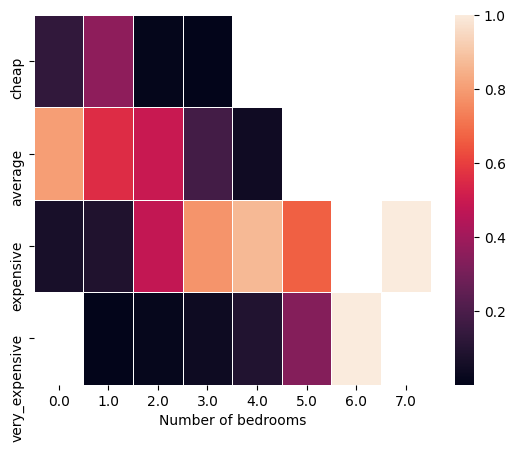

In [33]:
price_order = ['cheap','average','expensive','very_expensive']
ax = sns.heatmap(bedroom_price_norm.loc[price_order], cmap='rocket', linewidth=0.5);
ax.set_ylabel('');
# ax.set_yticks([price_order]);
ax.set_xlabel('Number of bedrooms');

### Visual data inspectation

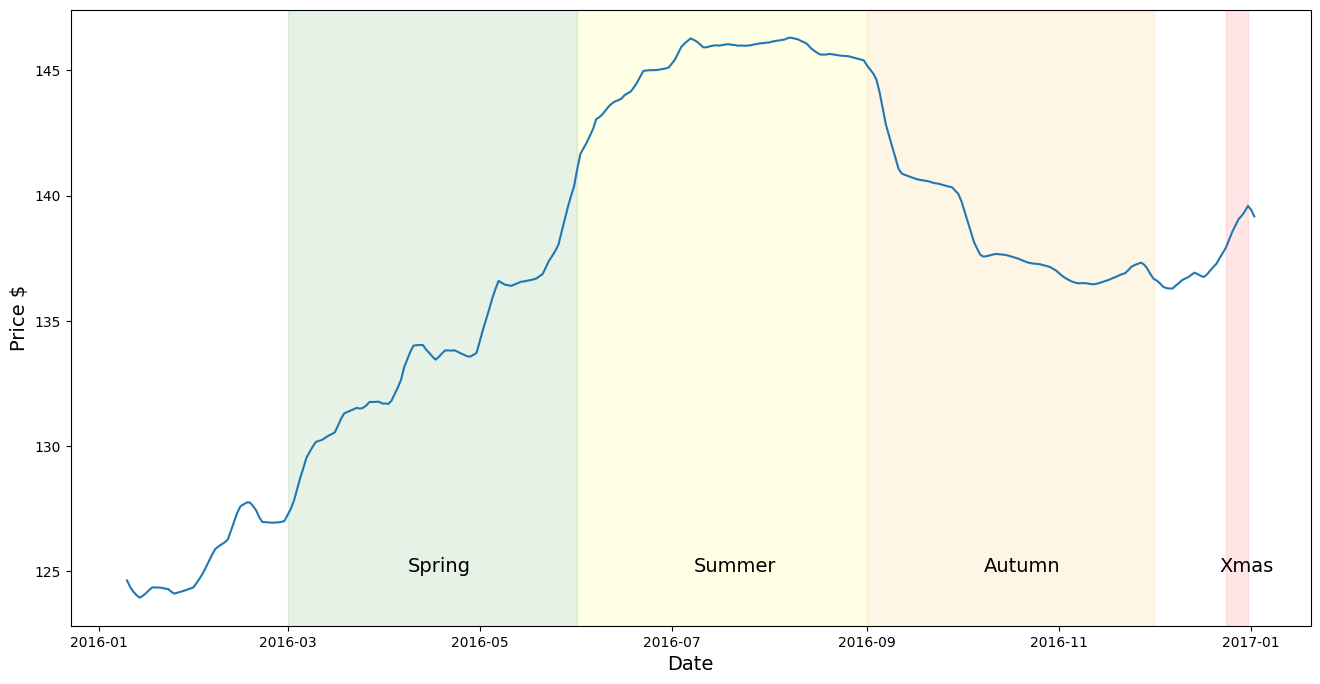

In [34]:
fig, ax = plt.subplots(figsize=(16,8))

plot_df = (df.set_index('date')
           .resample('D')
           [['price_coalesce']]
           .mean()
           .rolling(7)
           .mean()
           .reset_index()
          )
plot_df.columns = ['date','price']


sns.lineplot(x='date',
             y='price',
             data=plot_df,
             ax=ax
            )

# ax.set_title('7d rolling average price per night', fontsize=20);
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Price $', fontsize=14);

# Add spans for the seasons
ax.axvspan(xmin='2016-03-01', xmax='2016-06-01', alpha=0.1, color='green')
ax.text(x=pd.to_datetime('2016-04-08'), y=125, s='Spring', fontsize=14)

ax.axvspan(xmin='2016-06-01', xmax='2016-09-01', alpha=0.1, color='yellow')
ax.text(x=pd.to_datetime('2016-07-08'), y=125, s='Summer', fontsize=14);

ax.axvspan(xmin='2016-09-01', xmax='2016-12-01', alpha=0.1, color='orange')
ax.text(x=pd.to_datetime('2016-10-08'), y=125, s='Autumn', fontsize=14);

ax.axvspan(xmin='2016-12-24', xmax='2016-12-31', alpha=0.1, color='red')
ax.text(x=pd.to_datetime('2016-12-22'), y=125, s='Xmas', fontsize=14);

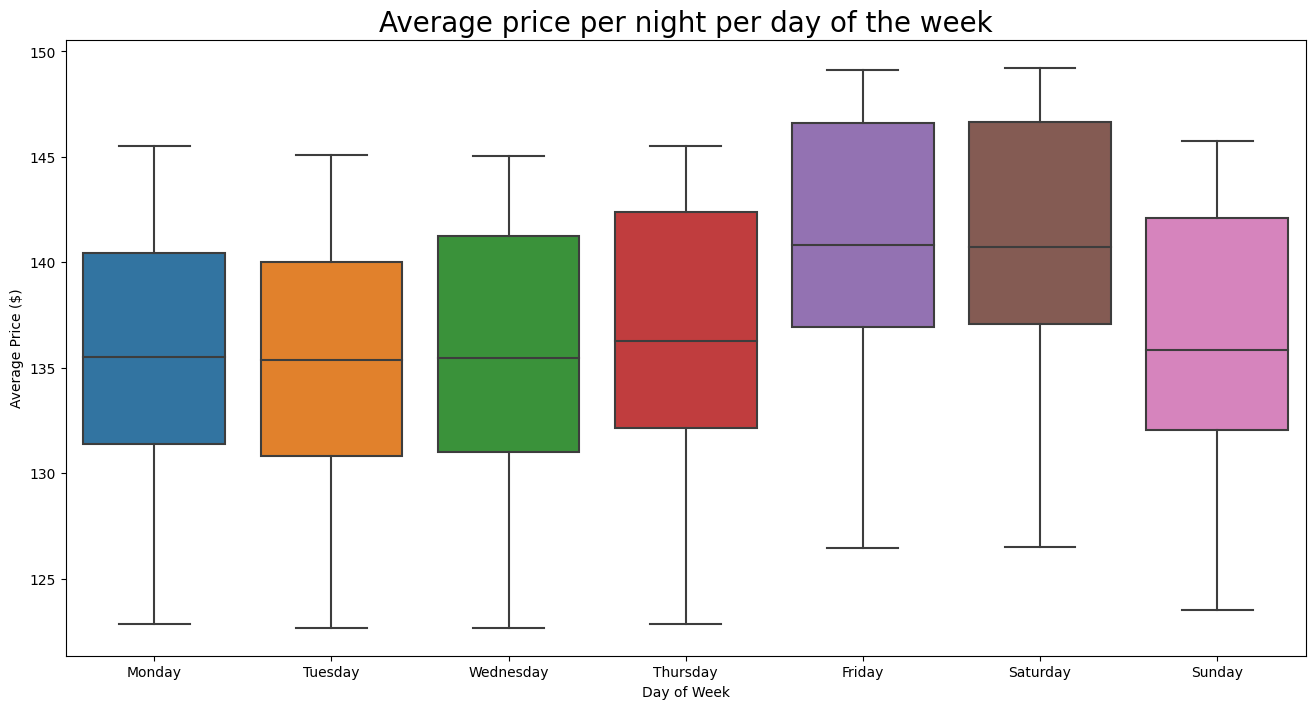

In [35]:
weekly_seasonality = (df.pivot_table(index='date', columns='day_of_week', values='price_coalesce', aggfunc='mean')
                      .unstack()
                      .dropna()
                      .reset_index()
                     )
weekly_seasonality.columns = ['Day of Week','date','Average Price ($)']
weekly_seasonality['sort_date'] = weekly_seasonality.date.dt.day_of_week
weekly_seasonality.sort_values(by='sort_date', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x='Day of Week',y='Average Price ($)', data=weekly_seasonality);

ax.set_title('Average price per night per day of the week', fontsize=20);

## Looking at the neighbourhood and price
Create a boxplot to display the price differences per neighbourhood group

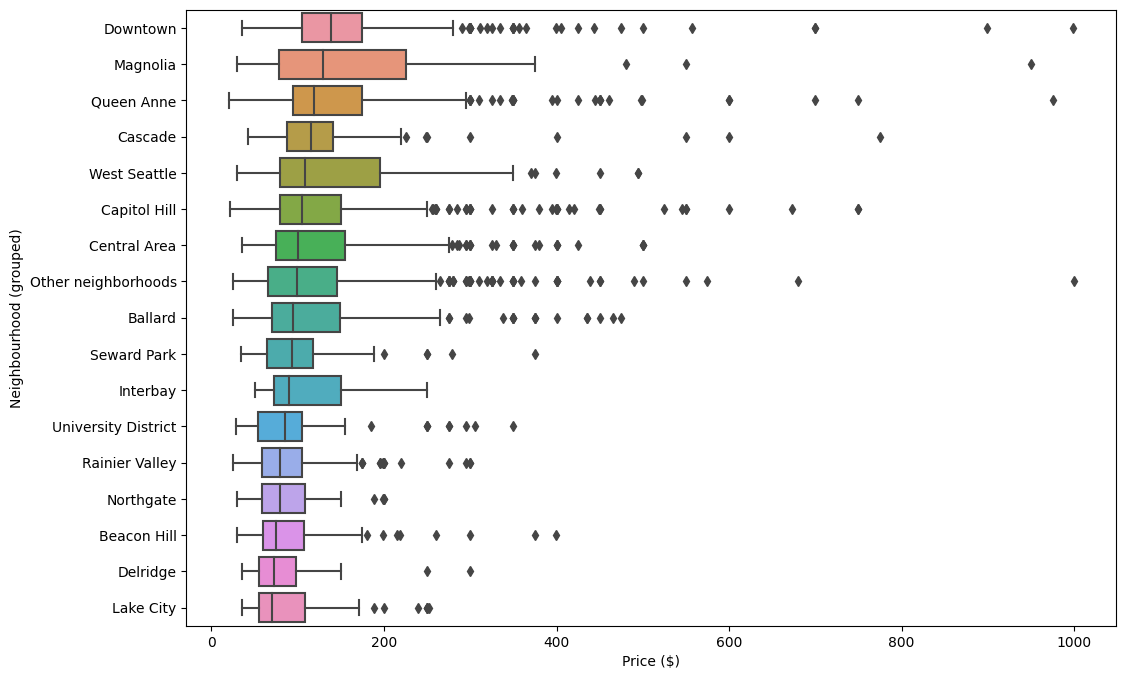

In [36]:
# Get the order of the neighbourhoods per price, based on median values
neighbourhood_order = (listings.groupby('neighbourhood_group_cleansed')
                       .price
                       .median()
                       .sort_values(ascending=False)
                       .index
                       .tolist()
                      )
# Create a boxplot
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=listings, y='neighbourhood_group_cleansed', x='price', orient='h', order=neighbourhood_order)
ax.set_ylabel('Neighbourhood (grouped)')
ax.set_xlabel('Price ($)');

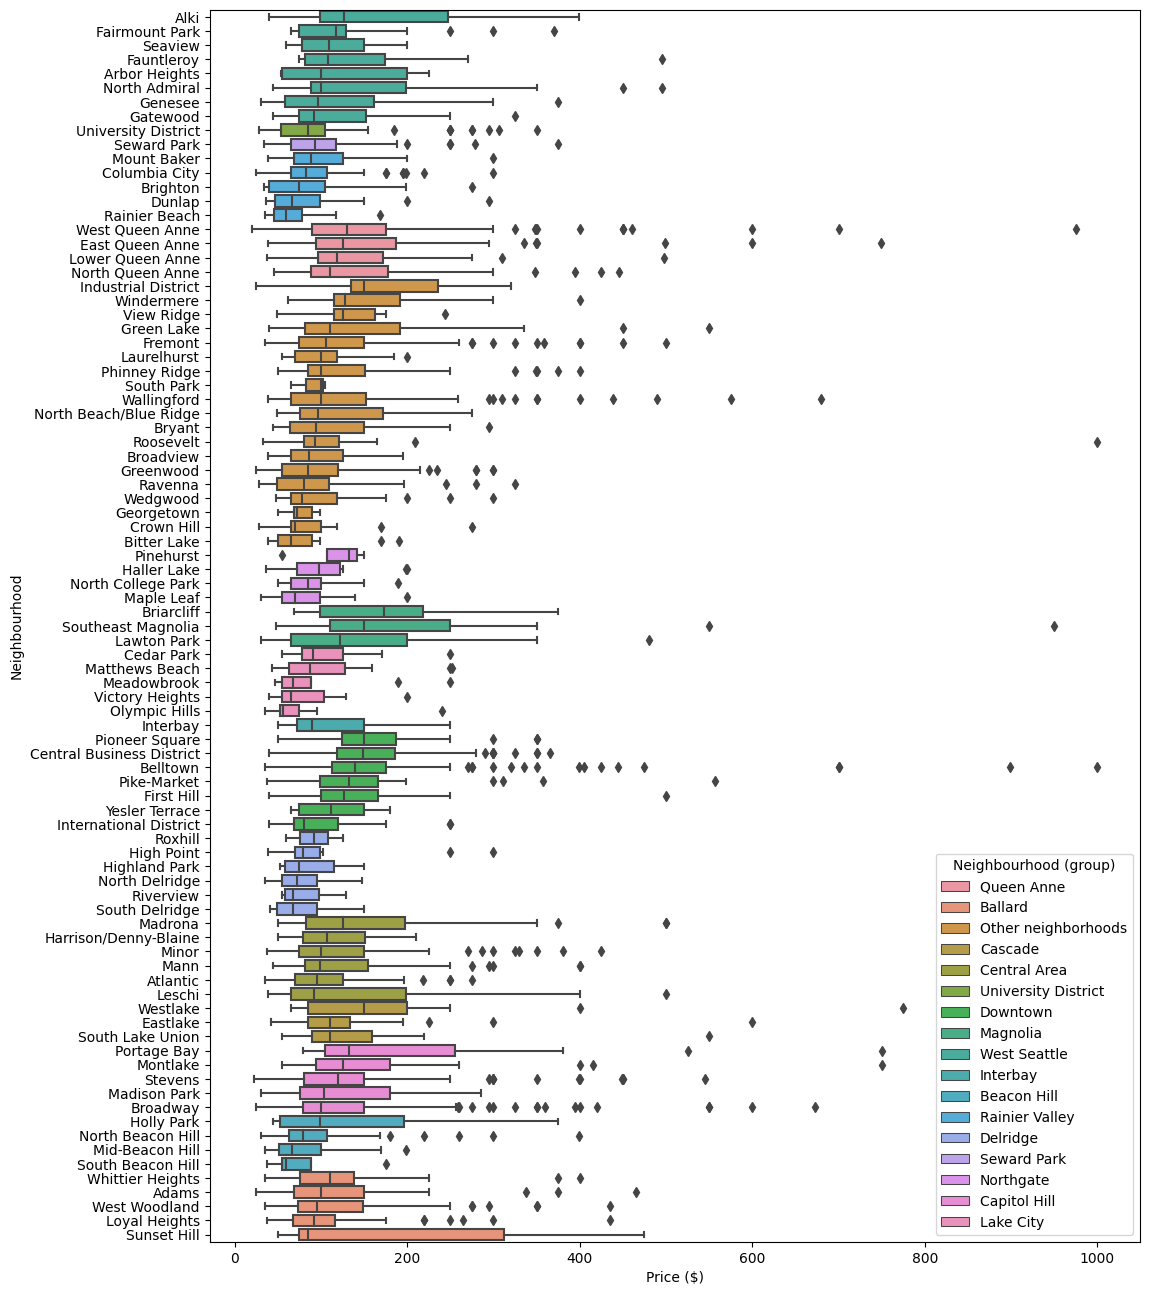

In [37]:
# Get the order of the neighbourhoods per price and grouped neighbourhood, based on median values
neighbourhood_order = (listings.groupby(['neighbourhood_group_cleansed','neighbourhood_cleansed'])
                       .price
                       .median()
                       .to_frame()
                       .reset_index()
                       .sort_values(by=['neighbourhood_group_cleansed','price'],ascending=False)
                       .neighbourhood_cleansed
                       .tolist()
                      )
neighbourhood_order
# Create a boxplot
fig, ax = plt.subplots(figsize=(12,16))
sns.boxplot(data=listings,
            y='neighbourhood_cleansed',
            x='price',
            hue='neighbourhood_group_cleansed',
            dodge=False,
            orient='h',
            order=neighbourhood_order
           )

ax.legend(title='Neighbourhood (group)')
ax.set_ylabel('Neighbourhood')
ax.set_xlabel('Price ($)');

# Regression model to predict the price and find important variables


## Missing data imputations - part two
First have a look at the missing values for the listings. From the barplot below there are a few crucial fields that will have to be filled or dropped. The following columns will be considered 

- `bedrooms` --> Manual imputation, just a few values
- `bathrooms` --> Filled with 1 for NAs, this is the most common value
- `beds` --> Filled with 1 for NAs, this is the most common value
- `review_score_rating` -> replace with mean value, the reviews all score very high.

Only a few missing values for bedrooms etc, use the text from space and summary to see if we can extract the data manually

After missing values where filled in the remaining columns with missing values will be dropped as they provide low information, or the information is available in another form (for example, the neighbourhood information).

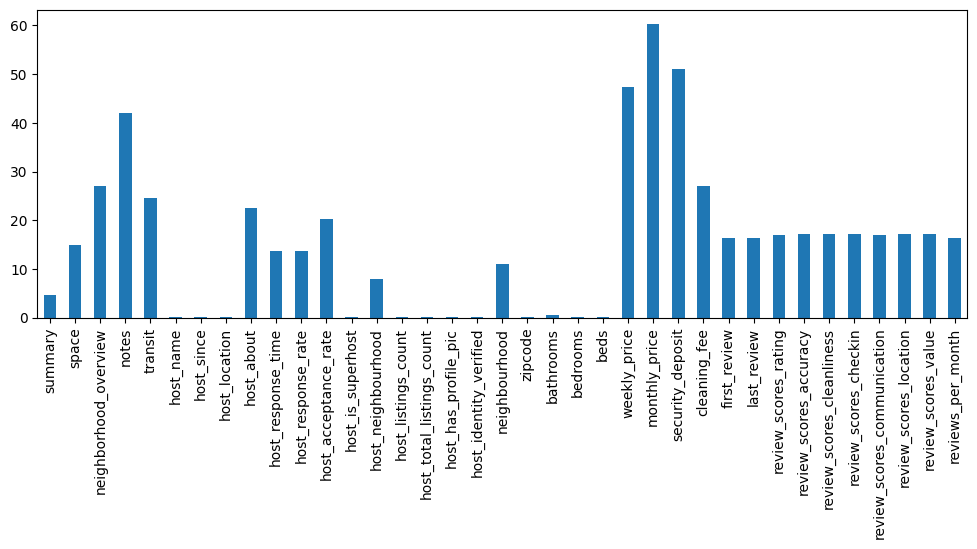

In [38]:
## Plot missing values
(listings.isnull().mean()*100)[~listings.notnull().all()].plot(kind='bar', figsize=(12,4));

#### Fill in missing values for bedroom, bathroom and beds

In [39]:
bedrooms_to_impute = listings[listings.bedrooms.isnull()]['id'].values.tolist()
print(bedrooms_to_impute)

[1476298, 604600, 1251763, 17951, 948077, 3272374]


In [40]:
## Manual walkthrough to create the mapping for imputation
bedrooms = {
    1476298: 0, # Studio --> 1 room so no seperate bedroom
    604600: 0, # Studio
    1251763: 1, # 1 bed in the living area, 1 bedroom
    17951: 0, # Studio
    948077: 0, # Space describes 1 room with everything
    3272374: 0 # Studio
}
listings.loc[listings.id.isin(bedrooms_to_impute),['id','summary','space','property_type','bedrooms','bathrooms','beds']]

,id,summary,space,property_type,bedrooms,bathrooms,beds
1429,1476298,NaN,You will love the location! Heart of Downtown....,Apartment,NaN,1.0,1.0
1492,604600,studio (2 ppl) through 2 bedroom units (6 ppl)...,Please send message for availability. Price is...,Apartment,NaN,1.0,1.0
1493,1251763,*** When booking a Friday or Saturday night st...,*Important: Contact me to tell me your preferr...,Other,NaN,1.0,2.0
1853,17951,Our spacious studio accommodates two guests. ...,In the front alcove is a queen-sized Sleep Num...,Apartment,NaN,1.0,1.0
2619,948077,"Small Space, Big Style, Spectacular Location w...","Small Space, Big Style, Spectacular Location w...",House,NaN,1.0,1.0
2915,3272374,This large studio apartment comfortably fits t...,My studio apartment is in a gorgeous old build...,Apartment,NaN,1.0,1.0


In [41]:
# Check if all values where imputed
for key, value in bedrooms.items():
    print(key, value)
    listings.loc[listings.id == key,'bedrooms'] = value

# Check if values are imputed
if listings[listings.bedrooms.isnull()]['id'].values.tolist() == []:
    print('all done!')

1476298 0
604600 0
1251763 1
17951 0
948077 0
3272374 0
all done!


In [42]:
# Impute bathrooms, most common value
listings.loc[listings.bathrooms.isnull(),'bathrooms'] = listings.bathrooms.mode()[0]

In [43]:
# Impute beds, most common value
listings.loc[listings.beds.isnull(),'beds'] = listings.beds.mode()[0]

In [44]:
# Impute review score rating with rounded mean
listings.loc[listings.review_scores_rating.isnull(),'review_scores_rating'] = listings.review_scores_rating.mean().round()

In [45]:
listings = listings.dropna(axis=1)

## Feature Engineering: Selecting the important features
Before training the model we'll have a look at the features we currently have.


**Identifying columns to remove**
- **High percentage missing values**
  - As shown above some of these features have over 30% missing values. In these cases the imputation might heavily influence the performance of the regressor. There features will be removed from the dataset.
- **Unique**
  - Columns like `id`, describing the listing identifier, do not provide general information to be used in the regressor. Being unique they don't contribute to explaining the variance of the data thus they do not add to the performance of the regressor.
  - Features like `space` are free text fields, language processing is required to extract more information from this field. In its current raw form it will be dropped as it doesn't add anything to the regressor. Everything with a higher variance of 10% in the features will be dropped
- **Only one value**
  - Similar to the unique values, columns with only one value do not enrich the regressor with information about the listings. These include fields like `scrape_id`
  
  
**Change boolean columns to int**  
The following columns are actually boolean columns, changing the data type to a numeric type like int will eliminate the need to introduce dummy variables for these, reducing the number of features without impacting the information density of the data set.
- `instant_bookable`
- `require_guest_profile_picture`
- `require_guest_phone_verification`

**remap `calendar_updated` columns**
The `calendar_updated` column tells us something on the amount of time passed since the listing was last updated. As we saw from the plots above, time has a big influence on the price. As its currently provided the column has a lot of different values which spreads out the core information we are interested in. We will map the values to 4 categories:
- updated this week
- updated this month
- updated last 6 months
- updated over 6 months ago


`host_verfifications` was dropped as a nested field. Before this can be used it needs to be unnested.

In [46]:
## Collect and drop columns with high variances and no variances.
col_drop_high_var = []
col_drop_no_var = []

n_listings = listings.shape[0]
for col in listings.columns:
    
    unique_size = listings[col].unique().size
    if unique_size == 1:
        col_drop_no_var.append(col)
        
    ratio = unique_size/n_listings
    if ratio > 0.1:
        col_drop_high_var.append(col)
        
    print(f'{col:<35} - {unique_size:<4} - {ratio*100:.1f}%')
    
print(f'\nCols to drop due to high variance: {col_drop_high_var}\nCols to drop due to low variance:  {col_drop_no_var}')

## Drop the columns
listings_v2 = listings.drop(columns=col_drop_high_var)
listings_v2 = listings_v2.drop(columns=col_drop_no_var)

id                                  - 3818 - 100.0%
listing_url                         - 3818 - 100.0%
scrape_id                           - 1    - 0.0%
last_scraped                        - 1    - 0.0%
name                                - 3792 - 99.3%
description                         - 3742 - 98.0%
host_id                             - 2751 - 72.1%
host_verifications                  - 116  - 3.0%
street                              - 1442 - 37.8%
neighbourhood_cleansed              - 87   - 2.3%
neighbourhood_group_cleansed        - 17   - 0.4%
latitude                            - 3818 - 100.0%
longitude                           - 3818 - 100.0%
is_location_exact                   - 2    - 0.1%
property_type                       - 16   - 0.4%
room_type                           - 3    - 0.1%
accommodates                        - 15   - 0.4%
bathrooms                           - 12   - 0.3%
bedrooms                            - 8    - 0.2%
beds                                - 

In [47]:
## Change type on boolean columns
bool_cols = ['instant_bookable','require_guest_profile_picture','require_guest_phone_verification']


listings_v2.loc[:, bool_cols] = listings_v2[bool_cols].replace({'t':1,'f':0}).astype(int)


In [48]:
## Map the calender_update to a list of values
calender_update_map = {}
for value in listings_v2.calendar_updated.unique():
    replace = 'over 6 months'
    
    if 'day' in value:
        replace = 'this week'
    elif 'week ago' in value or value == '2 weeks ago' or value == '3 weeks ago' or value == '4 weeks ago':
        replace = 'this month'
    elif 'week' in value or value == '2 months ago' or value == '3 months ago' or value == '4 months ago' or value == '5 months ago':
        replace = 'last 6 months'
        
    calender_update_map[value] = replace

listings_v2['calendar_updated_clean'] = listings_v2.calendar_updated.replace(calender_update_map)
listings_v2.calendar_updated_clean.value_counts()

this week        1500
this month       1134
last 6 months    1060
over 6 months     124
Name: calendar_updated_clean, dtype: int64

In [49]:
listings.columns.tolist()
feature_cols = ['neighbourhood_cleansed',
                 'neighbourhood_group_cleansed',
                 'property_type',
                 'room_type',
                 'accommodates',
                 'bathrooms',
                 'bedrooms',
                 'beds',
                 'bed_type',
                 'price',
                 'minimum_nights',
                 'maximum_nights',
                 'number_of_reviews',
                 'review_scores_rating',
                 'property_category'
                ]

# RandomForest regressor
- Describe the regression columns picked to include for feature importance
  - Most of the columns are numerical values, so easy to user without dummy variables
  - Some of the variables cut out are either `unique values`, have a terrible `skewed distribution` or have 1 value for everything
- Show the important ranked feateres sorted from low to high

In [50]:
def clean_data(df, y_col='price'):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no prices
    2. Create X as all the columns that are not the price column
    3. Create y as the price column
    4. Drop any price related columns from X
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing salary values
    y = df[y_col]
    
    #Drop respondent and expected salary columns
    df = df.drop(columns=[y_col])
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(listings)    

In [51]:
## Selected regression_cols, after testing these performed the best

regression_cols = [
    'neighbourhood_group_cleansed',
    'property_category',
    'cancellation_policy',
    'review_scores_rating',
    'availability_365',
    'calculated_host_listings_count',
    'room_type',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'number_of_reviews',
    'calendar_updated_clean',
    'price' # y_value
                  ]
listings_v2.drop(columns='price_category', inplace=True) # Drop the price category


#define dataset
X, y = clean_data(listings_v2[regression_cols])

# Split train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [52]:
# Use 600 trees, 300 performed worse, so did 1000. Picked a value in the middle
forest = RandomForestRegressor(n_estimators=600,)
forest.fit(X_train, y_train)

# r2 score, between 0 and 1 (can be negative if the model is really bad).
# Describes the % of variance caught, so the closer to 1 the better the model
print(f'r2 score of the regressor: {forest.score(X_test, y_test):.4f}')

# MAE makes sense here, as we are talking about a difference in money in a regression
# it is more likely that it resonates better when communicating the results 
print(f'Mean Absolute Error of the regressor: ${mean_absolute_error(y_test, forest.predict(X_test)):.2f}')

r2 score of the regressor: 0.6438
Mean Absolute Error of the regressor: $33.28


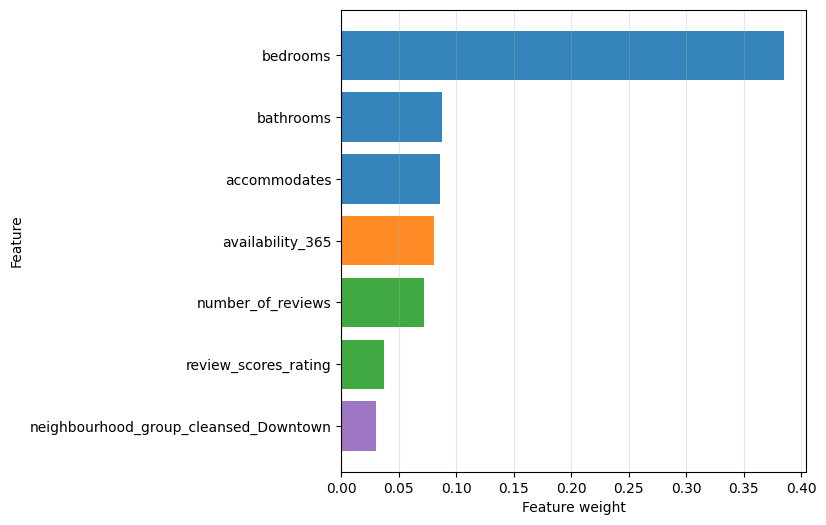

In [53]:
# Plot the feature importance ranking, Add color per "group". Groups here are made by hand
fig, ax = plt.subplots(figsize=(6,6))

feature_ranks = pd.DataFrame(data={'feature':X.columns.tolist(), 'importance':forest.feature_importances_})
feature_ranks = feature_ranks.sort_values(by='importance', ascending=True).tail(7)

color = ['#9467bd','#2ca02c','#2ca02c','#ff7f0e','#1f77b4','#1f77b4','#1f77b4']

plt.barh(feature_ranks.feature, feature_ranks.importance, color=color, alpha=0.9);

# ax.set_title('Seven most important features in the Randomforest Regressor');
ax.set_ylabel('Feature');
ax.set_xlabel('Feature weight');
ax.xaxis.grid(True, alpha=0.3);